<a href="https://colab.research.google.com/github/Aadil404/Machine-Learning-Lab/blob/main/Assignment-3/Assignment_3_3_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, Reshape, LSTM, AveragePooling2D, Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from itertools import cycle

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
# Load the MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a channel dimension (since MNIST images are grayscale)
x_train_full = np.expand_dims(x_train_full, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode the labels
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Define class names
class_names = [str(i) for i in range(10)]

print("Shape of training data:", x_train_full.shape)
print("Shape of test data:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Shape of training data: (60000, 28, 28, 1)
Shape of test data: (10000, 28, 28, 1)


In [3]:
# Function to plot training history (accuracy and loss)
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{model_name} Training History', fontsize=16)

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot ROC/AUC curves
def plot_roc_auc(y_true, y_pred_proba, n_classes, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) for {model_name}', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [4]:
# --- Simplified VGG-style model ---
def build_vgg_simple(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        # Classifier
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# --- Simplified AlexNet-style model ---
def build_alexnet_simple(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# --- Simplified GoogLeNet-style model (with one Inception module) ---
def inception_module_simple(x, f1, f2, f3):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(x)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(x)
    # concatenate filters
    layer_out = Concatenate(axis=-1)([conv1, conv3, conv5])
    return layer_out

def build_googlenet_simple(input_shape=(28, 28, 1), num_classes=10):
    input_layer = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = inception_module_simple(x, 16, 16, 16)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x) # Flatten the output of the MaxPooling2D layer
    x = Dense(num_classes, activation='softmax')(x) # Pass the flattened tensor as a keyword argument
    model = Model(inputs=input_layer, outputs=x)
    return model

# --- RNN (with LSTM) ---
# For MNIST, we treat each of the 28 rows of pixels as a time step.
def build_rnn(input_shape=(28, 28, 1), num_classes=10):
    model = Sequential([
        Reshape((input_shape[0], input_shape[1]), input_shape=input_shape),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [5]:
# --- Configuration ---
SPLITS = [0.1, 0.2] # Corresponds to 90/10 and 80/20 train/validation splits
EPOCHS = 10
BATCH_SIZE = 128

# Dictionary to store all our results
results = {}

# Dictionary of models to train
models_to_train = {
    "VGG (Simple)": build_vgg_simple,
    "AlexNet (Simple)": build_alexnet_simple,
    "GoogLeNet (Simple)": build_googlenet_simple,
    "RNN (LSTM)": build_rnn,
}

In [6]:
best_models = {}

for model_name, model_builder in models_to_train.items():
    print(f"==================== Training {model_name} ====================")
    best_accuracy = 0.0

    for split_val in SPLITS:
        print(f"\n----- Using Validation Split: {split_val*100:.0f}% -----")

        x_train, x_val, y_train, y_val = train_test_split(
            x_train_full, y_train_full, test_size=split_val, random_state=42
        )

        model = model_builder()
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(x_val, y_val),
                            verbose=1)

        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

        result_key = f"{model_name} (Val Split {split_val*100:.0f}%)"
        results[result_key] = {'test_loss': test_loss, 'test_accuracy': test_acc}
        print(f"Test Accuracy for {result_key}: {test_acc:.4f}")

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_models[model_name] = {
                'model': model,
                'history': history,
                'test_accuracy': test_acc,
                'split': split_val
            }

print("\n==================== Training Complete ====================")

==================== Training VGG (Simple) ====================

----- Using Validation Split: 10% -----


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.8074 - loss: 0.5848 - val_accuracy: 0.9843 - val_loss: 0.0508
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9743 - loss: 0.0893 - val_accuracy: 0.9888 - val_loss: 0.0367
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9814 - loss: 0.0611 - val_accuracy: 0.9902 - val_loss: 0.0327
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9881 - loss: 0.0406 - val_accuracy: 0.9917 - val_loss: 0.0311
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9884 - loss: 0.0362 - val_accuracy: 0.9897 - val_loss: 0.0421
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9903 - loss: 0.0327 - val_accuracy: 0.9930 - val_loss: 0.0314
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9918 - loss: 0.0234 - val_accuracy: 0.9902 - val_loss: 0.0358
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9913 - loss: 0.0273 - val_accuracy: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5559 - loss: 1.2826 - val_accuracy: 0.9407 - val_loss: 0.2044
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9318 - loss: 0.2596 - val_accuracy: 0.9627 - val_loss: 0.1266
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9596 - loss: 0.1577 - val_accuracy: 0.9735 - val_loss: 0.0918
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9688 - loss: 0.1215 - val_accuracy: 0.9748 - val_loss: 0.0834
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9746 - loss: 0.0971 - val_accuracy: 0.9755 - val_loss: 0.0849
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9790 - loss: 0.0836 - val_accuracy: 0.9770 - val_loss: 0.0883
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9815 - loss: 0.0724 - val_accuracy: 0.9845 - val_loss: 0.0595
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9837 - loss: 0.0642 - val_accuracy: 0.


--- Generating plots for best VGG (Simple) (Val Split: 20%) ---


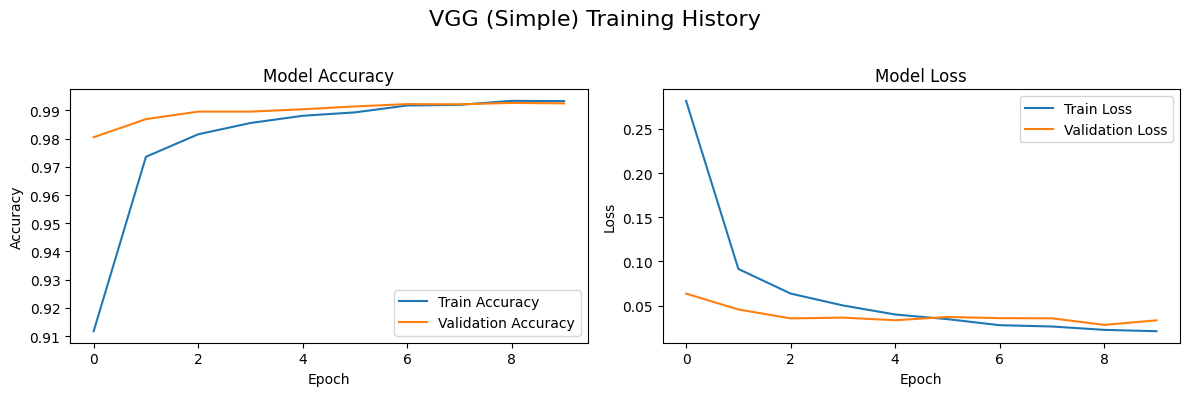

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


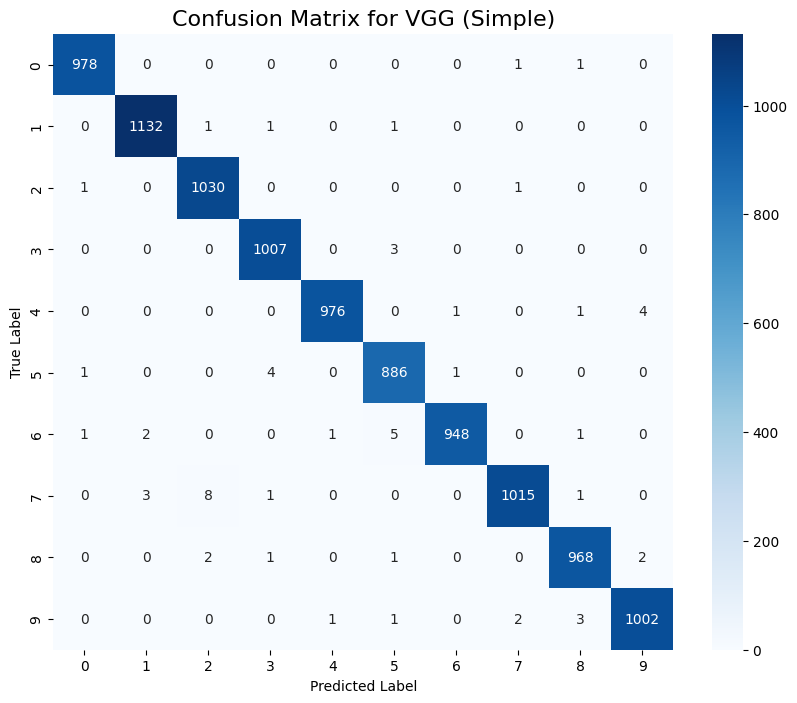

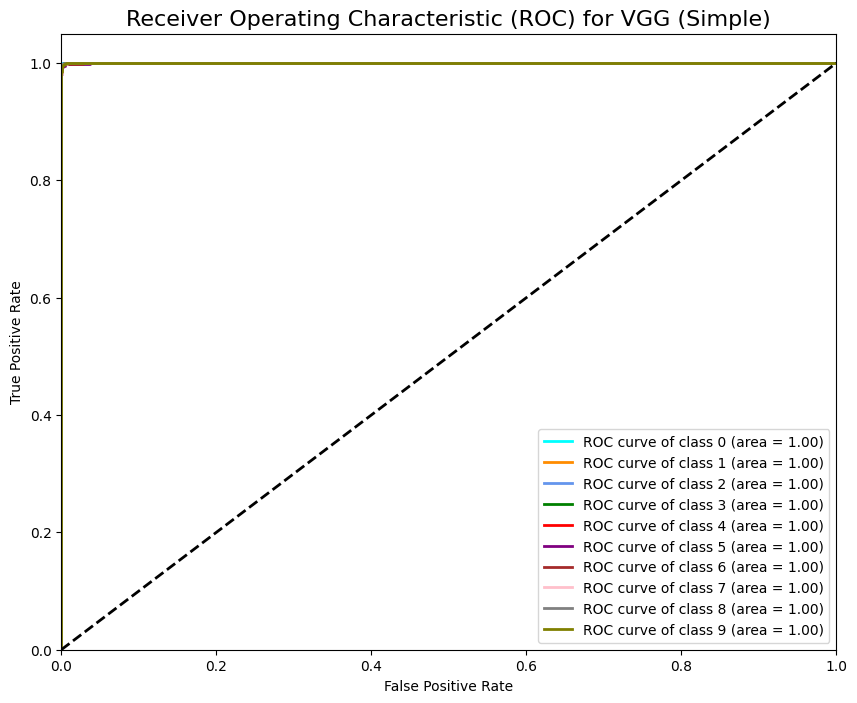


--- Generating plots for best AlexNet (Simple) (Val Split: 10%) ---


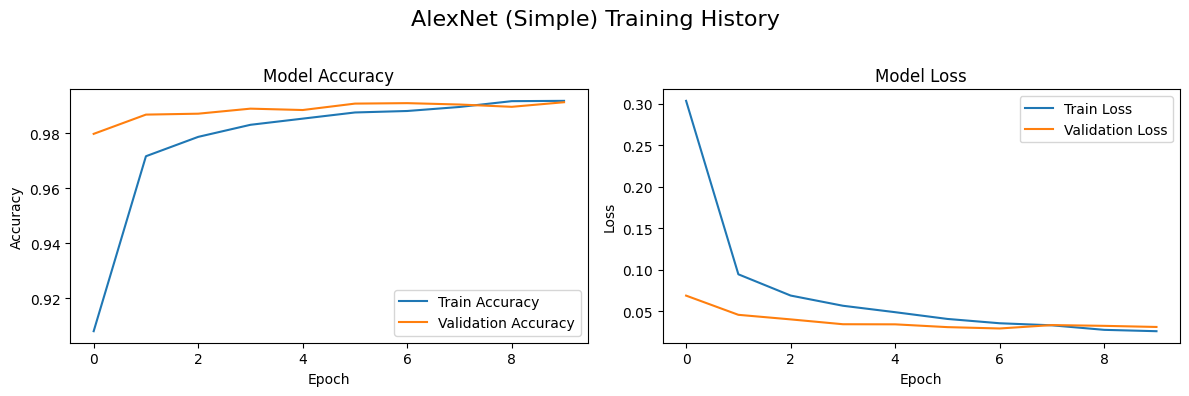

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


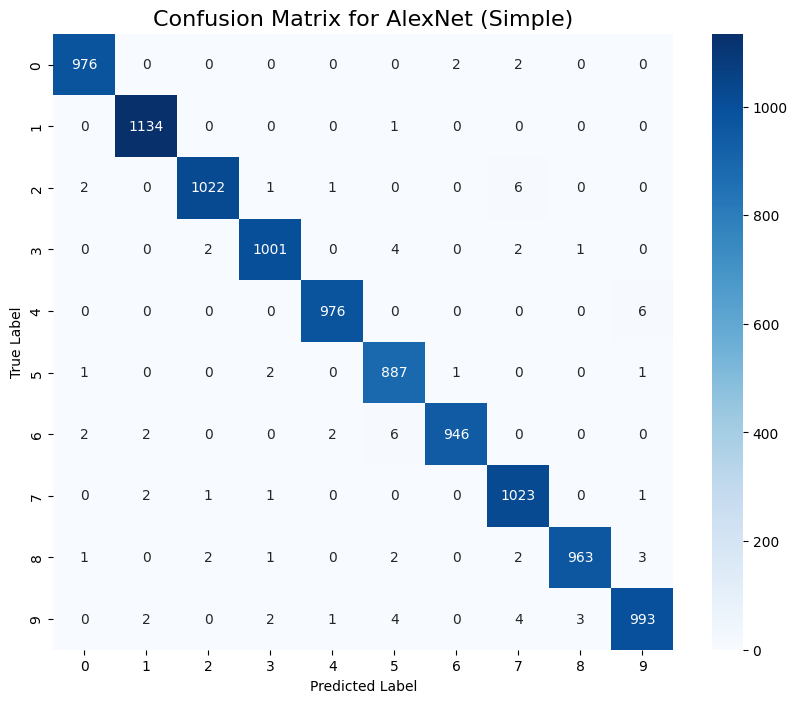

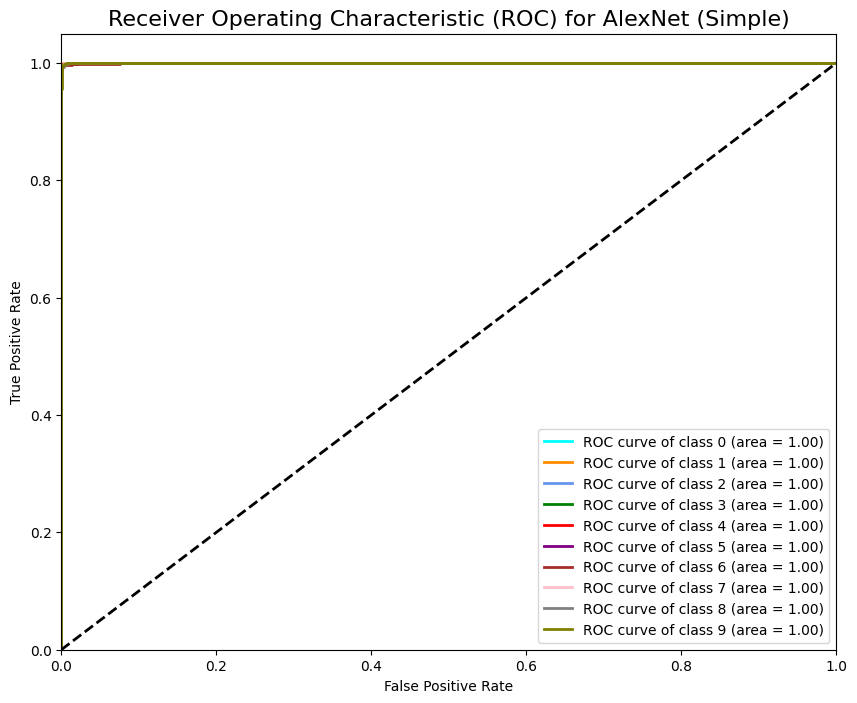


--- Generating plots for best GoogLeNet (Simple) (Val Split: 20%) ---


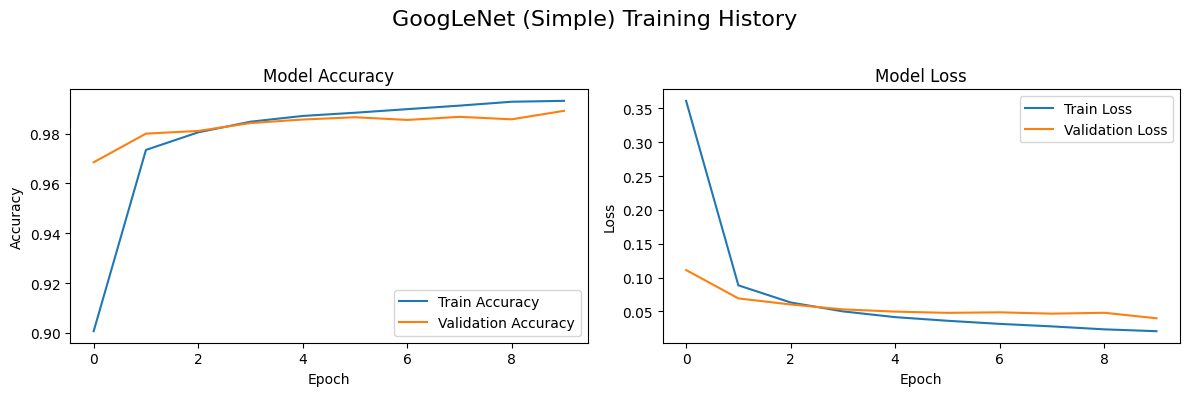

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


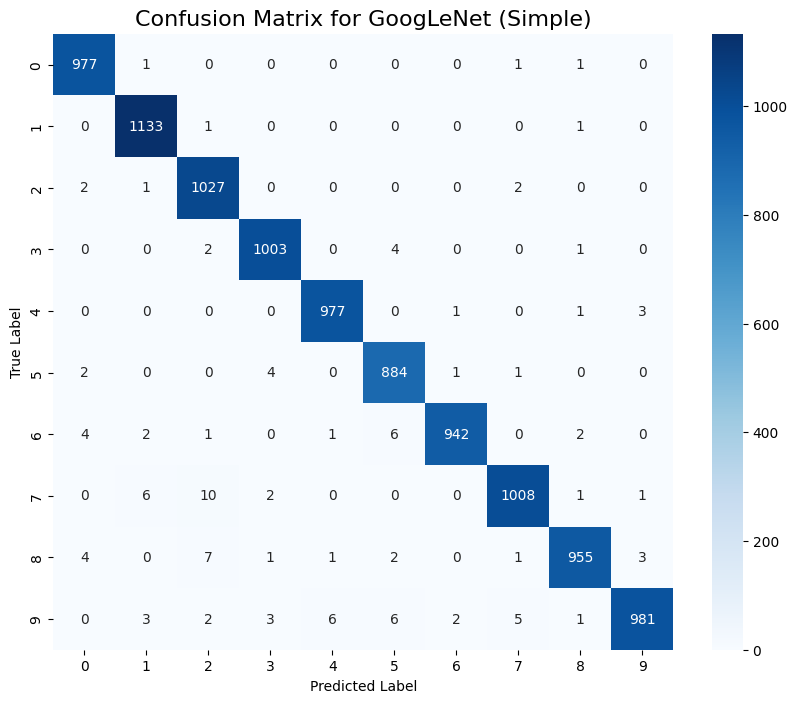

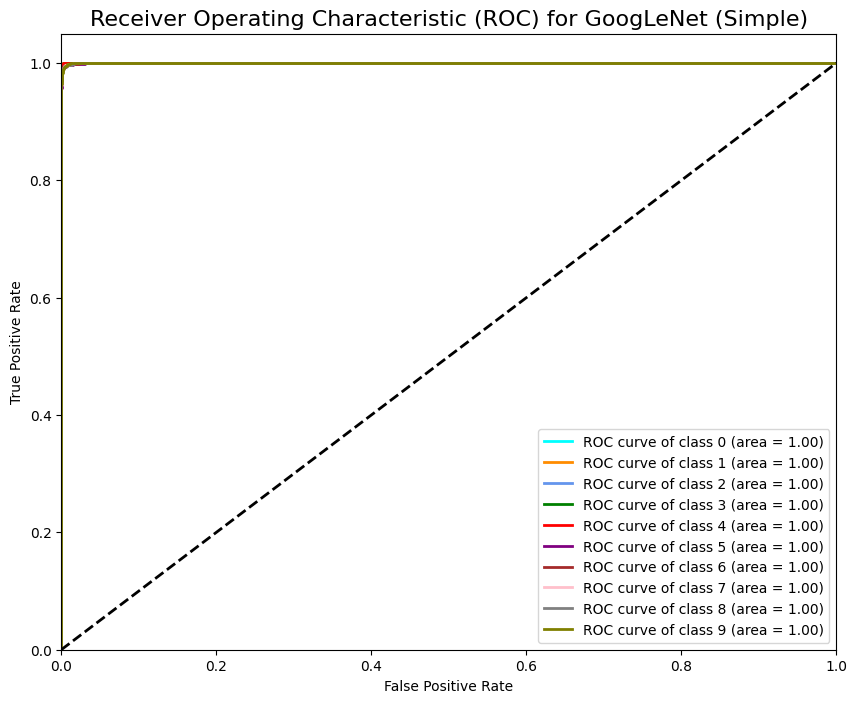


--- Generating plots for best RNN (LSTM) (Val Split: 10%) ---


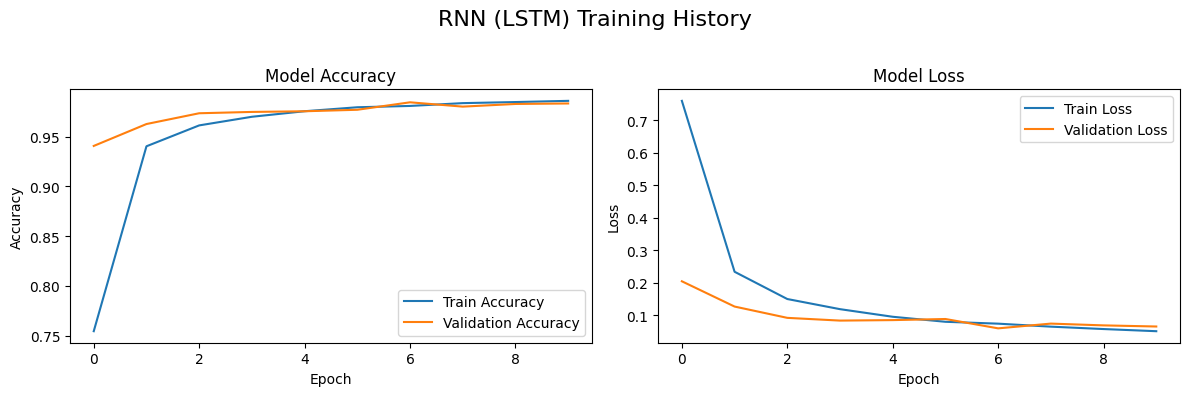

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


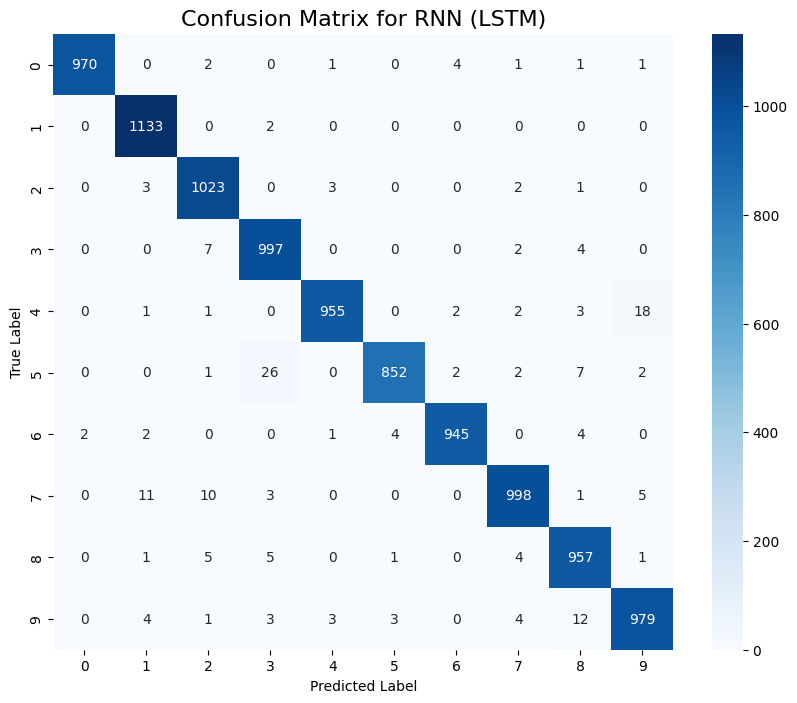

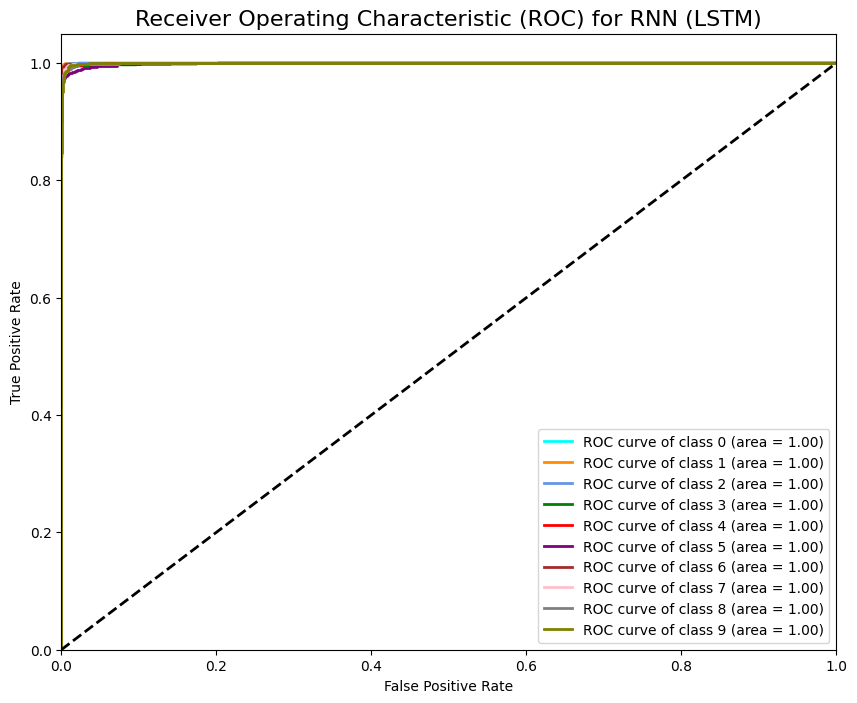

In [7]:
for model_name, data in best_models.items():
    print(f"\n--- Generating plots for best {model_name} (Val Split: {data['split']*100:.0f}%) ---")

    model = data['model']
    history = data['history']

    # 1. Plot Training & Validation Curves
    plot_history(history, model_name)

    # 2. Generate predictions
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # 3. Plot Confusion Matrix
    plot_confusion_matrix(y_test_labels, y_pred, class_names, model_name)

    # 4. Plot ROC/AUC Curve
    plot_roc_auc(y_test, y_pred_proba, n_classes=len(class_names), model_name=model_name)

In [8]:
# Convert results dictionary to a Pandas DataFrame for easy viewing
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_index()

print("==================== Performance Comparison on MNIST ====================")
print(results_df)

==================== Performance Comparison on MNIST ====================
                                    test_loss  test_accuracy
AlexNet (Simple) (Val Split 10%)     0.022809         0.9921
AlexNet (Simple) (Val Split 20%)     0.026478         0.9911
GoogLeNet (Simple) (Val Split 10%)   0.035066         0.9885
GoogLeNet (Simple) (Val Split 20%)   0.035241         0.9887
RNN (LSTM) (Val Split 10%)           0.071020         0.9809
RNN (LSTM) (Val Split 20%)           0.065692         0.9809
VGG (Simple) (Val Split 10%)         0.019945         0.9937
VGG (Simple) (Val Split 20%)         0.019748         0.9942
